## Configuração de Ambiente

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Exploração dos Dados

In [3]:
url = 'https://raw.githubusercontent.com/UnB-CIS/UnB-CIS-UEG-MPhysChem/refs/heads/main/4_Dia/delaney-processed.csv'
df = pd.read_csv(url)
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [4]:
df.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


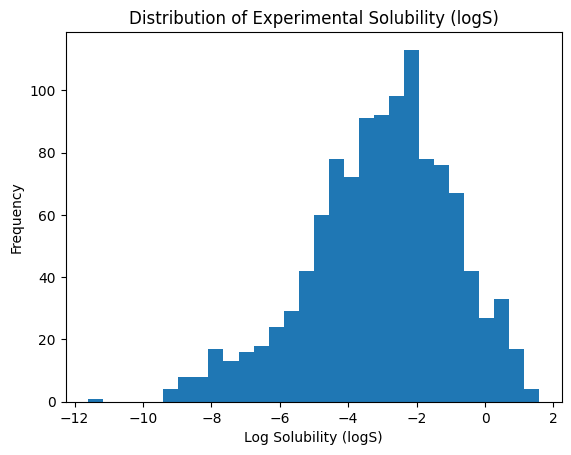

In [5]:
plt.figure()
plt.hist(df["measured log solubility in mols per litre"], bins=30)
plt.xlabel("Log Solubility (logS)")
plt.ylabel("Frequency")
plt.title("Distribution of Experimental Solubility (logS)")
plt.show()

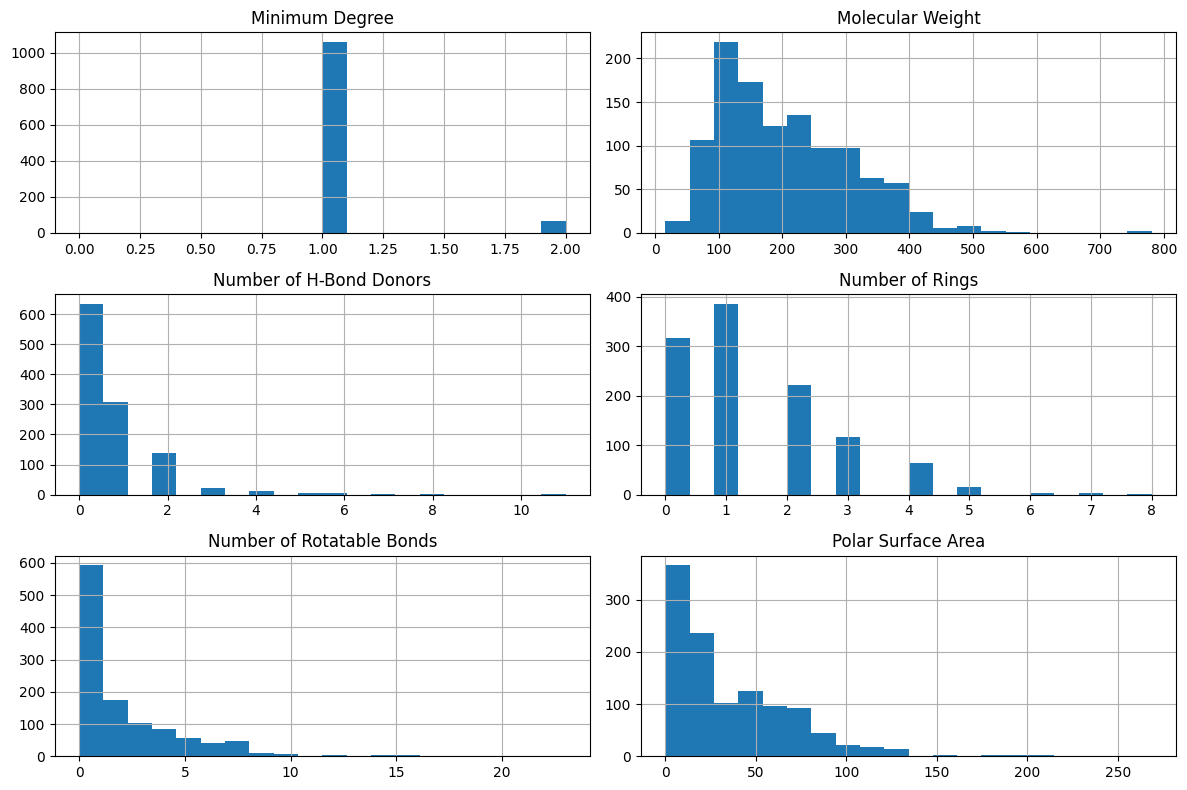

In [6]:
features = [
    "Minimum Degree",
    "Molecular Weight",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area"
]

df[features].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

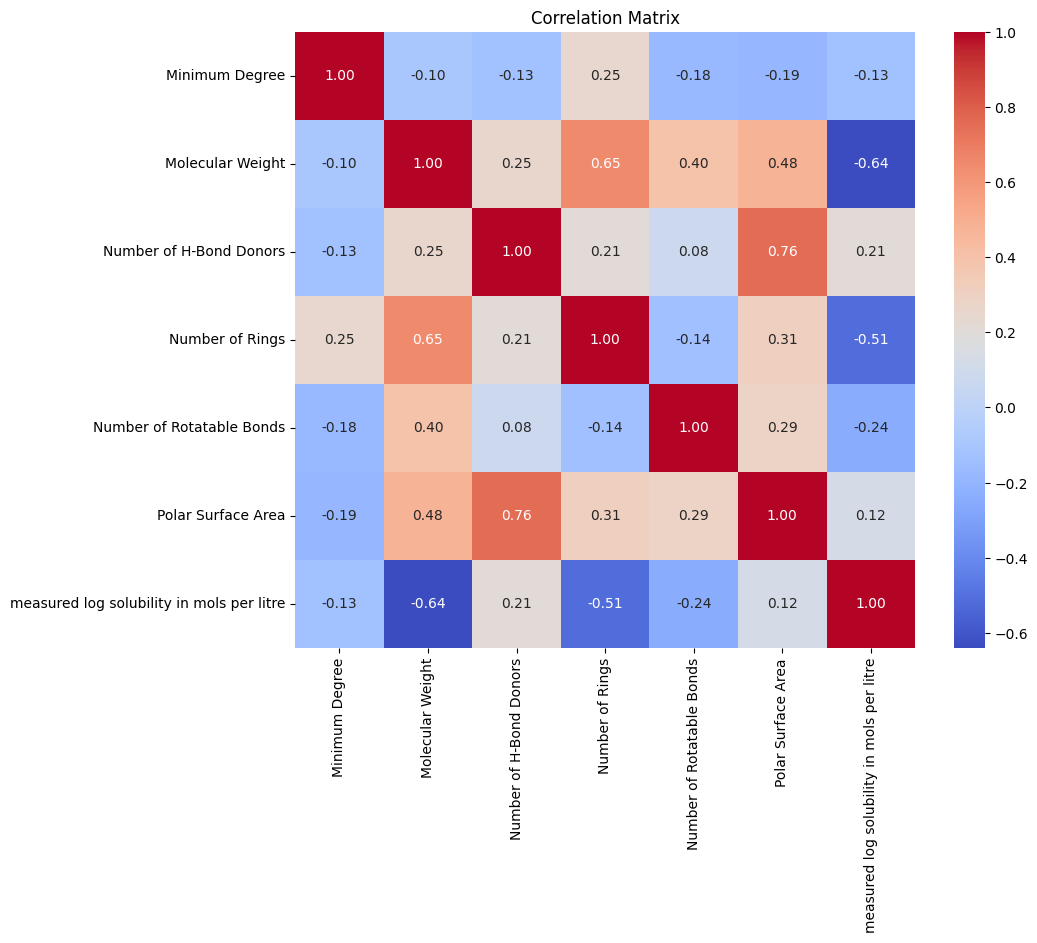

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[features + ["measured log solubility in mols per litre"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix")
plt.show()

## Feature Selection

Nesta etapa, definimos quais variáveis do dataset serão utilizadas como **entradas do modelo (features)** e qual será a **variável alvo (target)**.

### Features (variáveis de entrada)
As features selecionadas representam descritores físico-químicos das moléculas, capturando informações estruturais relevantes para a predição da solubilidade:

- **Minimum Degree**  
- **Molecular Weight**  
- **Number of H-Bond Donors**  
- **Number of Rings**  
- **Number of Rotatable Bonds**  
- **Polar Surface Area**

Esses descritores traduzem propriedades químicas em valores numéricos, permitindo que a rede neural aprenda padrões a partir dos dados.

### Target (variável alvo)
O modelo tem como objetivo prever:

- **measured log solubility in mols per litre**

Esse valor corresponde à **solubilidade experimental real da molécula em água**, expressa em escala logarítmica (*logS*).

### Objetivo desta etapa
Definir corretamente as features e o target é fundamental para:
- garantir coerência química do modelo
- reduzir ruído nos dados
- facilitar a interpretação dos resultados

Nesta abordagem, estamos lidando com um problema clássico de **regressão QSAR**.


In [8]:
features = [
    "Minimum Degree",
    "Molecular Weight",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area"
]

target = "measured log solubility in mols per litre"

X = df[features].values
y = df[target].values.reshape(-1, 1)

In [11]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
X

array([[-0.2453752 ,  2.46848464,  5.78268892,  1.22109812,  1.82691435,
         4.73443703],
       [-0.2453752 , -0.02640966,  0.27428095,  0.46220077, -0.06716597,
         0.20829955],
       [-0.2453752 , -0.50344534, -0.64378704, -1.05559391,  0.69046616,
        -0.50336262],
       ...,
       [-0.2453752 ,  0.41309652, -0.64378704, -1.05559391,  1.82691435,
        -0.46406145],
       [-0.2453752 , -1.28330735, -0.64378704, -1.05559391, -0.44598203,
        -0.98600359],
       [-0.2453752 ,  1.57778691, -0.64378704, -0.29669657,  1.06928222,
         0.27955059]])

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([902, 6]),
 torch.Size([226, 6]),
 torch.Size([902, 1]),
 torch.Size([226, 1]))

In [13]:
X_train

tensor([[-0.2454, -0.7963,  0.2743, -0.2967, -0.8248, -0.4140],
        [-0.2454, -1.2641, -0.6438, -1.0556, -0.0672, -0.7250],
        [-0.2454,  0.0305, -0.6438,  0.4622, -0.8248, -0.9860],
        ...,
        [-0.2454,  0.8211,  3.0285,  1.2211, -0.4460,  2.0456],
        [-0.2454, -0.6505, -0.6438, -0.2967, -0.4460,  0.1221],
        [-0.2454, -1.2833, -0.6438, -1.0556, -0.4460, -0.9860]])

In [16]:
y_train[:5]

tensor([[-1.4000],
        [-0.3900],
        [-4.4000],
        [-2.6760],
        [-8.0000]])

## Criação do Modelo

Nesta etapa, definimos a **arquitetura da rede neural** que será utilizada para aprender a relação entre os descritores moleculares e a solubilidade das moléculas.

### Arquitetura escolhida
O modelo adotado é uma **Multilayer Perceptron (MLP)**, composta por:

- **Camada de entrada**  
  Recebe os descritores físico-químicos selecionados na etapa de *Feature Selection*.

- **Duas camadas ocultas (hidden layers)**  
  Responsáveis por aprender representações não lineares dos dados.

- **Camada de saída**  
  Produz um valor contínuo correspondente à solubilidade prevista (*logS*).

### Função de ativação
Utilizamos a função de ativação **ReLU (Rectified Linear Unit)** nas camadas ocultas.

A escolha da ReLU se deve a:
- maior estabilidade no treinamento
- redução do problema de *vanishing gradients*
- boa performance em redes profundas

### Motivação da arquitetura
Essa arquitetura simples é adequada porque:
- o dataset possui tamanho moderado
- o problema é de **regressão contínua**
- evita *overfitting* excessivo
- serve como um bom **baseline** para modelos mais complexos

A MLP permite capturar relações **não lineares** entre propriedades químicas e solubilidade.


In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train.shape[1])

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Treinamento do Modelo

Nesta etapa, realizamos o **treinamento da rede neural**, onde o modelo aprende a ajustar seus parâmetros para minimizar o erro entre as previsões e os valores reais de solubilidade.

> **Observação importante:**  
> O treinamento é realizado utilizando o **conjunto de treinamento**, enquanto o **conjunto de teste** é reservado exclusivamente para a avaliação final do modelo.

---

### Processo de treinamento
O treinamento ocorre de forma iterativa ao longo de várias **épocas (epochs)**.  
Em cada época, o modelo:

1. Recebe os dados de entrada (descritores moleculares)
2. Produz uma previsão de solubilidade
3. Calcula o erro por meio da função de perda
4. Atualiza seus pesos via retropropagação (*backpropagation*)

---

### Número de épocas
Definimos um número fixo de épocas, que representa quantas vezes o modelo verá todo o conjunto de treinamento.

- Muitas épocas → risco de *overfitting*  
- Poucas épocas → risco de *underfitting*

Por isso, utilizamos técnicas como **Early Stopping** para interromper o treinamento quando não há mais melhora significativa.

---

### Parâmetros de treinamento
Durante o treinamento, definimos os seguintes hiperparâmetros:

- **Função de perda:**  
  *Mean Squared Error (MSE)*, adequada para problemas de regressão.

- **Otimizador:**  
  Ajusta os pesos do modelo com base no gradiente da função de perda (ex: Adam ou SGD).

- **Taxa de aprendizado (*learning rate*):**  
  Controla o tamanho do passo na atualização dos pesos.

---

### Objetivo do treinamento
O objetivo final é aprender uma função que mapeie:

descritores moleculares → solubilidade experimental (logS)

In [19]:
# Uma época é a quantidade de vezes que o modelo vai fazer o processo de treinamento
epochs = 200

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Train MSE: {loss.item():.4f}")

Epoch 000 | Train MSE: 13.4659
Epoch 020 | Train MSE: 9.3885
Epoch 040 | Train MSE: 5.0667
Epoch 060 | Train MSE: 2.8585
Epoch 080 | Train MSE: 2.0312
Epoch 100 | Train MSE: 1.7101
Epoch 120 | Train MSE: 1.5155
Epoch 140 | Train MSE: 1.3525
Epoch 160 | Train MSE: 1.2221
Epoch 180 | Train MSE: 1.1195


## Avaliação do Modelo

Nesta etapa, avaliamos o desempenho do modelo utilizando o **conjunto de teste**, composto por amostras que **não foram vistas durante o treinamento**.

A avaliação permite verificar:
- a capacidade de generalização do modelo
- se o aprendizado obtido no treinamento é representativo
- a presença de problemas como *overfitting* ou *underfitting*

---

### Conjunto de teste
O conjunto de teste é utilizado exclusivamente para avaliação final, garantindo uma estimativa justa do desempenho do modelo em dados novos.

---

### Métricas de avaliação
Para medir a qualidade das previsões, utilizamos métricas apropriadas para problemas de regressão, como:

- **Mean Squared Error (MSE)**  
  Penaliza erros maiores e é sensível a outliers.

- **Root Mean Squared Error (RMSE)**  
  Expressa o erro médio na mesma unidade da variável alvo (*logS*), facilitando a interpretação.

---

### Interpretação dos resultados
Comparando o desempenho nos conjuntos de treinamento e teste, podemos identificar:

- **Bom ajuste:**  
  Erros semelhantes em treino e teste indicam boa generalização.

- **Overfitting:**  
  Erro muito baixo no treino e alto no teste indica que o modelo memorizou os dados.

- **Underfitting:**  
  Erros elevados em ambos os conjuntos indicam que o modelo é simples demais.

---

### Objetivo da avaliação
Garantir que o modelo consiga prever corretamente a **solubilidade de moléculas não vistas**, o que é essencial para aplicações reais em **química computacional e descoberta de fármacos**.


In [20]:
model.eval()

with torch.no_grad():
    y_test_pred = model(X_test).numpy()
    y_test_true = y_test.numpy()

mse = mean_squared_error(y_test_true, y_test_pred)
rmse = np.sqrt(mse)

print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MSE : 1.2243
Test RMSE: 1.1065


In [21]:
y_esol = df["ESOL predicted log solubility in mols per litre"].values
y_esol_train, y_esol_test = train_test_split(
    y_esol, test_size=0.2, random_state=42
)

In [22]:
# Escolher uma amostra específica do conjunto de teste
idx = 1  # você pode trocar o índice para visualizar outra molécula

# Selecionar a amostra
x_sample = X_test[idx].unsqueeze(0)  # adiciona dimensão batch
y_true = y_test[idx].item()
y_esol_baseline = y_esol_test[idx]

# Fazer a previsão com o modelo treinado
with torch.no_grad():
    y_pred = model(x_sample).item()

# Exibir resultados
print("🧪 Descritores da molécula:")
for name, value in zip(features, X_test[idx].tolist()):
    print(f"  {name}: {value:.3f}")

print("\n🎯 Solubilidade real (logS):", round(y_true, 3))

print("\n📊 Predições:")
print("🤖 Modelo MLP (Deep Learning):", round(y_pred, 3))
print("📐 ESOL (baseline clássico):", round(y_esol_baseline, 3))

print("\n📉 Erros absolutos:")
print("Erro do modelo:", round(abs(y_true - y_pred), 3))
print("Erro do ESOL :", round(abs(y_true - y_esol_baseline), 3))

🧪 Descritores da molécula:
  Minimum Degree: -0.245
  Molecular Weight: 0.198
  Number of H-Bond Donors: 1.192
  Number of Rings: -0.297
  Number of Rotatable Bonds: 0.312
  Polar Surface Area: 1.142

🎯 Solubilidade real (logS): -2.253

📊 Predições:
🤖 Modelo MLP (Deep Learning): -1.976
📐 ESOL (baseline clássico): -2.126

📉 Erros absolutos:
Erro do modelo: 0.277
Erro do ESOL : 0.127
